In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this[:, -1, :]  (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [34]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW

import pandas as pd
import numpy as np

import re

import warnings
warnings.simplefilter("ignore")

import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm


In [3]:
import requests

url = "https://www.gutenberg.org/files/100/100-0.txt"  # Shakespeare Corpus
response = requests.get(url)
text_data = response.text

# Save the dataset locally
with open("shakespeare.txt", "w", encoding="utf-8") as file:
    file.write(text_data)

print("Dataset saved successfully!")

Dataset saved successfully!


In [4]:
with open("shakespeare.txt", 'r', encoding='utf-8') as f:
            lines = f.readlines()

In [5]:
def clean_text(text):
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text).strip() 
    return text

In [6]:
text = []
for line in lines:
    text.append(clean_text(line))

cleaned_text = [t for t in text if t != ""]

cleaned_text_final =[]

for i in range(49, len(cleaned_text)):
    cleaned_text_final.append(cleaned_text[i])

text = cleaned_text_final

In [7]:
text

['From fairest creatures we desire increase,',
 'That thereby beauty’s rose might never die,',
 'But as the riper should by time decease,',
 'His tender heir might bear his memory:',
 'But thou contracted to thine own bright eyes,',
 'Feed’st thy light’s flame with self-substantial fuel,',
 'Making a famine where abundance lies,',
 'Thyself thy foe, to thy sweet self too cruel:',
 'Thou that art now the world’s fresh ornament,',
 'And only herald to the gaudy spring,',
 'Within thine own bud buriest thy content,',
 'And, tender churl, mak’st waste in niggarding:',
 'Pity the world, or else this glutton be,',
 'To eat the world’s due, by the grave and thee.',
 'When forty winters shall besiege thy brow,',
 'And dig deep trenches in thy beauty’s field,',
 'Thy youth’s proud livery so gazed on now,',
 'Will be a tattered weed of small worth held:',
 'Then being asked, where all thy beauty lies,',
 'Where all the treasure of thy lusty days;',
 'To say, within thine own deep sunken eyes,',


In [8]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")

tokenizer.pad_token = tokenizer.eos_token

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [9]:
max_chars = []
for t in text:
    max_chars.append(len(t))

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


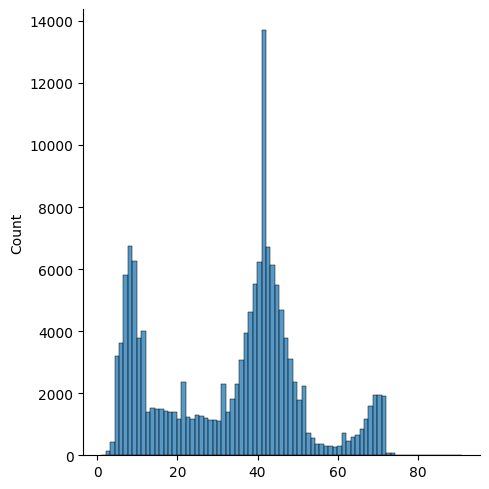

In [10]:
sns.displot(max_chars)
plt.show()

In [11]:
text[0].split()

['From', 'fairest', 'creatures', 'we', 'desire', 'increase,']

In [12]:
max_length = 80
class ShakespeareDataset(Dataset):
    def __init__(self, text, tokenizer):
        self.input = text
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.input)

    def __getitem__(self, idx):
        encodings = self.tokenizer.encode_plus(self.input[idx], 
                                                max_length = max_length, 
                                                pad_to_max_length = True,
                                                return_token_type_ids =False,
                                                return_tensors = "pt")
        return {
            "input_ids": encodings["input_ids"],
            "attention_mask": encodings["attention_mask"],
            "labels": encodings["input_ids"]
        }


In [13]:
train_dataset = ShakespeareDataset(text, tokenizer)

In [14]:
batch_size = 32
train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle = True)

In [15]:
data = next(iter(train_dl))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2673: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [16]:
data["labels"].shape, data["input_ids"].shape, data["attention_mask"].shape

(torch.Size([32, 1, 80]), torch.Size([32, 1, 80]), torch.Size([32, 1, 80]))

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [18]:
output = model(input_ids = data["input_ids"].to(device), attention_mask=data["attention_mask"].to(device), labels = data["labels"])

In [19]:
optimizer = AdamW(model.parameters(), lr=0.0001)

In [20]:
epochs = 1
def train_model(model, dataloader, optimizer, epochs=epochs):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        total_correct = 0
        total_samples = 0
        
        print("=" * 100)
        print(f"Epoch {epoch + 1}/{epochs}: ")
        
        for batch in tqdm(dataloader, desc=f"Training Epoch {epoch + 1}"):
            inputs = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            optimizer.zero_grad()

            outputs = model(input_ids=inputs, attention_mask=attention_mask, labels = labels)
            loss = outputs.loss

            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            preds = torch.argmax(outputs.logits, dim = -1)
            correct_predictions = (preds == labels)
            total_correct += correct_predictions.sum().item()
            total_samples += labels.numel()

        avg_loss = total_loss / len(dataloader)
        accuracy = total_correct / total_samples

        print(f"Epoch {epoch + 1}, Loss: {avg_loss:.2f}, Accuracy: {accuracy*100:.2f}%")


In [21]:
%%time
train_model(model, train_dl, optimizer)

Epoch 1/1: 


Training Epoch 1: 100%|██████████| 4795/4795 [31:03<00:00,  2.57it/s]

Epoch 1, Loss: 0.46, Accuracy: 87.92%
CPU times: user 31min 3s, sys: 2.53 s, total: 31min 5s
Wall time: 31min 3s


In [22]:
torch.save(model.state_dict(), "gpt-text-generation-shakespeare.pth")

In [23]:
prompt = "Thou shall"
inputs = tokenizer(prompt, return_tensors="pt").to(device)
output = model.generate(**inputs, min_length = 50, max_length = 1000, num_return_sequences = 1, temperature = 0.7,
                        top_k = 50, do_sample = True, eos_token_id=tokenizer.eos_token_id)
sentence = tokenizer.decode(output[0], skip_special_tokens = True)
print(sentence)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Thou shall do me wrong. But for the wrong of him, thou art not well, I am, thou art not good. I will be a good, and so I will. But I will, I will, and of my am.


In [24]:
len(sentence)

160

In [31]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

def compute_bleu(model, test_sentences):
    total_bleu = 0
    count = 0
    smoothing = SmoothingFunction().method1

    for sentence in test_sentences:
        inputs = tokenizer(sentence, return_tensors="pt").to(device)
        output = model.generate(**inputs, min_length = 50, max_length = 1000, num_return_sequences = 1, temperature = 0.7,
                        top_k = 50, do_sample = True, eos_token_id=tokenizer.eos_token_id)
        predicted_sentence = tokenizer.decode(output[0], skip_special_tokens = True)
       
        reference = [nltk.word_tokenize(sentence)]
        candidate = nltk.word_tokenize(predicted_sentence)

        bleu_score = sentence_bleu(reference, candidate, smoothing_function=smoothing)
        total_bleu += bleu_score
        count += 1

    return total_bleu / count if count > 0 else 0

In [35]:
test_sentences = [
    "Methinks the night be filled with dreams untold, where lovers’ sighs do dance upon the air.",
    "Thou art the fairest star that lights my path, and yet thy love doth fade as morning mist.",
    "O gentle breeze, dost thou carry word of love, or sighs of sorrow lost to time’s embrace?",
    "Upon this parchment doth my heart confess, in ink of longing and of love’s despair.",
    "Wouldst thou grant me but a fleeting glance, ere time dost steal thy visage from mine eyes?",
    "The wretched night doth linger long, and yet no solace greets my weary soul.",
    "Lo! The heavens weep with trembling stars, as though the gods dost mourn love’s cruel fate.",
    "A kiss, my love, and all the world is naught but echoes of thy whispered name.",
    "The dawn doth break, yet in mine heart remains the shadow of the night’s sweet sorrow."
]

bleu = compute_bleu(model, test_sentences)
print(f"BLEU Score: {bleu:.4f}")

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


BLEU Score: 0.4029
